In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from scipy import spatial
import os 
from sklearn.feature_extraction.text import CountVectorizer
# Para redes neuronales
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier


# Para el one-hot encoder
import category_encoders as ce

from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

# Representacion grafica
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

number_books_use_embeddings = 1

## Lectura de datos para embedding ingles

In [ ]:
def leerLibros(ruta):
    data_english = []

    book_names_english = sorted(os.listdir(ruta))
    if('.DS_Store' in book_names_english):
        book_names_english.remove('.DS_Store')

    for book in book_names_english:
        print("Vamos a leer el libro:", book)
        
        # Leemos el libro
        text = open(ruta +"/" + str(book), 'r', encoding="utf8").read()
        # Preprocesamos lo leido
        text = text.lower()
        text = re.sub(r'[0-9]+', '', text)
        text = re.sub(r'[,!?;-]+', ' .', text)
        
        # Añadimos a la lista el texto preprocesado
        data_english.append(text)
        
        print("El libro tiene {0} palabras\n".format(len(text.split(" "))))
    return data_english

## Aprendemos el vocabulario de ingles con CountVectorizer

In [ ]:
def obtenerVocabulario(data):
    vocabulary = []
    for libro in data:
        vocabulary.extend(nltk.word_tokenize(libro))
    vocabulary = [palabra for palabra in vocabulary if palabra.isalpha() or palabra=='.']
    vocabulary = list(set(vocabulary))
    return vocabulary

## Creamos la funcion para obtener las palabras contexto y su palabra central

In [ ]:
#filtrada = [lista for lista in lol if len(lista.split()) > 3]

def generate_context_word_pairs(corpus, context_size):
    # Creamos el tamaño de la ventana
    window = context_size*2 + 1
    
    # Se transfromar el texto almacenado en la lista: corpus a string para poder aplicar el split()
    corpus = str(corpus)
    corpus = corpus.split(".")
    
    # Para crear las palabtas de contexto hay que crearlas a prtir de una frase, un conjunto de palabras que estan entre puntos
    # por lo que separaremos el corpus por puntos y que ademas la frase tenga al menos el tamaño de la ventana para poder crear
    # el contexto y la palabra central
    corpus = [lista for lista in corpus if len(lista.split()) >= window]
    #print(corpus)
    for frase in corpus:
        frase = word_tokenize(frase)        
        for backward, current in enumerate(range(len(frase)-(2*context_size)-1), start = -window):
            if backward < 0: 
                backward = 0
                
            # Obtenemos todas las palabras que hay en la ventana
            words_window = frase[current+1:current+1+window]
            
            # Obtenemos la palabra central
            y = words_window[context_size]

            # Obtenemos las palabras de contexto
            x = words_window
            x.pop(context_size)
            yield (x, y)

## ONE HOT ENCODING PALABRAS DEL CONTEXTO Y CENTRALES

In [ ]:
def oneHot_contexto(vocabulario,context_word,central_word):
    # Creamos el codificador del One-Hot
    cod_one_hot = ce.OneHotEncoder()
    # Transformamos el vocabulario de ingles aprendido de un diccionario a una lista
    copy_vocabulary = list(vocabulario)
    # Entrenamos el codificador del One-Hot con el vocabulario de ingles aprendido
    cod_one_hot.fit(copy_vocabulary)

    print("Recordamos que en el vocabulario hay {0} palabras aprendidas".format(len(vocabulario)))

    # Aplicamos One-Hot a las palabras centrales
    central_word_oh = cod_one_hot.transform(central_word)
    print("Codificado palabras centrales en one-hot: \n", central_word_oh.shape)

    #### Listado con todas las palabras del contexto
    palabrasVocabulario = []
    for context in context_word:  
        for palabra in context:     
            palabrasVocabulario.append(palabra)

    #### Diccionario con los one hot de las palabras del contexto
    diccionarioOneHot = dict()
    for palabra in palabrasVocabulario:
        if ( palabra not in diccionarioOneHot ):
            diccionarioOneHot[palabra] = cod_one_hot.transform([palabra])
    print("Diccionario One hot completado")

    # Aplicamos One-Hot a las palabras de contexto
    context_word_oh = []
    for j,context in enumerate(context_word):
        suma = np.zeros((1,len(copy_vocabulary)))
        for i, word in enumerate(context):
            word_oh = diccionarioOneHot[word]          
            suma += np.array(word_oh)
        media = suma/len(context)
        context_word_oh.append(media)
        
    print("Codificado palabras contexto en one-hot: \n", len(context_word_oh))
    return context_word_oh,  central_word_oh

## Crear la matriz de contexto y palabra central para ingles

In [ ]:
def obtener_contexto_centro(data):
    context_word_english = []
    central_word_english = []
    # Solo vamos a leer un libro ( de momento )
    number_books_use_embeddings = 1
    for x, y in generate_context_word_pairs(data[:number_books_use_embeddings], context_size=2):
        context_word_english.append(x)
        central_word_english.append(y)
    print("Se han creado {0} conjuntos de palabras de contexto en ingles".format(len(context_word_english)))
    return context_word_english, central_word_english

In [ ]:
def distanciaCoseno(embedding1, embedding2):
    embedding1 = np.array([1,2,3])
    embedding2 = np.array([4,5,6])
    result = 1 - spatial.distance.cosine(embedding1, embedding2)
    return distancia

In [ ]:
def distanciaEuclidea(embedding1, embedding2):
    embedding1 = np.array([1,2,3])
    embedding2 = np.array([4,5,6])
    distancia = sum(np.sqrt(embedding2-embedding1)**2)
    return distancia

In [ ]:
def aplicarPCA(matrizEmbeddings):
    X = matrizEmbeddings.copy()
    pca = PCA(n_components=0.95, svd_solver='full')
    X = pca.fit(X)
    return X

In [ ]:
#funcion para crear fichero con dos columnas, una con el vocabulario en el lenguaje original y otra en el traducido
def traducirYGuardarVocabulario(vocabularioOriginal):
    translator = Translator()
    vocabularioTraducido = []
    for palabraTraducida in vocabularioOriginal:
        vocabularioTraducido.append(translator.translate(palabraTraducida , dest ='es').text)
    matrizTraducidas = np.array(vocabularioTraducido,dtype='str')
    matrizOriginales = np.array(vocabularioOriginal,dtype='str')
    matrizVocabularios = np.hstack((matrizOriginales.reshape(-1,1),matrizTraducidas.reshape(-1,1)))
    np.savetxt('vocabulario en dos columnas',matrizVocabularios, fmt="%s")
    return

In [ ]:
def gradientDescent(X, y, R, alpha=0.0000001, num_iters=1500):
    if(not isinstance(X, np.ndarray)):
        X = X.to_numpy()
    if(not isinstance(y, np.ndarray)):
        y = y.to_numpy()      
    for iteracion in np.arange(num_iters):
        h = X.dot(R)
        R = R - alpha * (X.T).dot((h - y)) * (1/(R.shape[0]*R.shape[1]))

    return R  

In [ ]:
def computeCost(X, y, R):
    h = X.dot(R)
    J = np.sum((h-y)**2)
    return(J)

In [ ]:
ruta_igles = "Copus_Embeddings/Libros_Ingles"
ruta_espanol = "Copus_Embeddings/Libros_Español"
data_english = leerLibros(ruta_igles)
data_spanish = leerLibros(ruta_espanol)

Vamos a leer el libro: Book1.txt
El libro tiene 90893 palabras

Vamos a leer el libro: Book2.txt
El libro tiene 101104 palabras

Vamos a leer el libro: Book3.txt
El libro tiene 128276 palabras

Vamos a leer el libro: Book4.txt
El libro tiene 226757 palabras

Vamos a leer el libro: Book5.txt
El libro tiene 303909 palabras

Vamos a leer el libro: Book6.txt
El libro tiene 201595 palabras

Vamos a leer el libro: Book7.txt
El libro tiene 234053 palabras

Vamos a leer el libro: J.K. Rowling - Harry Potter 1 - La Piedra Filosofal.txt
El libro tiene 81469 palabras

Vamos a leer el libro: J.K. Rowling - Harry Potter 2 - La Cámara Secreta.txt
El libro tiene 95657 palabras

Vamos a leer el libro: J.K. Rowling - Harry Potter 3 - El Prisionero de Azkaban.txt
El libro tiene 114229 palabras

Vamos a leer el libro: J.K. Rowling - Harry Potter 4 - El Cáliz de Fuego.txt
El libro tiene 207082 palabras

Vamos a leer el libro: J.K. Rowling - Harry Potter 5 - La Orden del Fenix.txt
El libro tiene 340488 p

In [ ]:
vocabulary_english = obtenerVocabulario(data_english[:number_books_use_embeddings])
vocabulary_spanish = obtenerVocabulario(data_spanish[:number_books_use_embeddings])
print(len(vocabulary_english))
print(len(vocabulary_spanish))

5666
8040


In [ ]:
context_word_english, central_word_english = obtener_contexto_centro(data_english)
context_word_spanish, central_word_spanish = obtener_contexto_centro(data_spanish)

Se han creado 39524 conjuntos de palabras de contexto en ingles
Se han creado 29038 conjuntos de palabras de contexto en ingles


In [ ]:
# context_word_english_oh, central_word_english_oh = oneHot_contexto(vocabulary_english,context_word_english,central_word_english)
# context_word_spanish_oh, central_word_spanish_oh = oneHot_contexto(vocabulary_spanish,context_word_spanish,central_word_spanish)

Recordamos que en el vocabulario hay 5666 palabras aprendidas
Codificado palabras centrales en one-hot: 
 (39524, 5666)
Codificado palabras contexto en one-hot: 
 39524
Recordamos que en el vocabulario hay 8040 palabras aprendidas
Codificado palabras centrales en one-hot: 
 (29038, 8040)
Codificado palabras contexto en one-hot: 
 29038


In [ ]:
# context_word_english_oh = np.array(context_word_english_oh)
# context_word_spanish_oh = np.array(context_word_spanish_oh)
# context_word_english_oh.shape
# context_word_spanish_oh.shape

(29038, 1, 8040)

In [ ]:
# np.savetxt('one hot ingles contexto',context_word_english_oh[:,0,:])
# np.savetxt('one hot ingles central',central_word_english_oh)
# np.savetxt('one hot español contexto',context_word_spanish_oh[:,0,:])
# np.savetxt('one hot español central',central_word_spanish_oh)

In [ ]:
# context_word_english_oh2 = np.loadtxt('one hot ingles contexto')
# central_word_english_oh2 = np.loadtxt('one hot ingles central')

# context_word_spanish_oh2 = np.loadtxt('one hot español contexto')
# central_word_spanish_oh2 = np.loadtxt('one hot español central')

## Red Neuronal para embeddings

In [ ]:
size_layer_input_output = len(vocabulary_english)
size_embedding = 200

print("Tamaño vocabulario (tam capa entrada y salida): ", size_layer_input_output)
print("Dimension embedding (tam capa oculta): ", size_embedding)

model = keras.models.Sequential([
    #Capa entrada
    keras.layers.Dense(size_embedding, activation='relu',input_shape=(size_layer_input_output,)),
    #Capa oculta
    keras.layers.Dense(size_layer_input_output, activation='softmax'),
])

#Se ajustan parametros del modelo, como la metrica rendimiento, el optimizador de la RN y el error 
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Imprimimos la arquitectura del modelo
print(model.summary())

Tamaño vocabulario (tam capa entrada y salida):  5666
Dimension embedding (tam capa oculta):  200
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               1133400   
                                                                 
 dense_9 (Dense)             (None, 5666)              1138866   
                                                                 
Total params: 2,272,266
Trainable params: 2,272,266
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# if(tf.config.list_physical_devices('GPU')):
#     with tf.device('/gpu:0'):
#         # Entrenamos la red neuronal
#         model.fit(context_word_english_oh2, central_word_english_oh2, epochs=5, batch_size=32, validation_split=0.2)
        
#         #Guardamos la red entrenada 
#         model.save('embeddings_english.h5')

Epoch 1/5
 11/989 [..............................] - ETA: 10s - loss: 7.5585 - accuracy: 0.0170    

2022-05-07 13:48:36.915587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


988/989 [============================>.] - ETA: 0s - loss: 5.4967 - accuracy: 0.0541

2022-05-07 13:48:48.407835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


989/989 [==============================] - 13s 13ms/step - loss: 5.4967 - accuracy: 0.0540 - val_loss: 5.2400 - val_accuracy: 0.0612
Epoch 2/5
989/989 [==============================] - 12s 13ms/step - loss: 5.0473 - accuracy: 0.0899 - val_loss: 5.5936 - val_accuracy: 0.1050
Epoch 3/5
989/989 [==============================] - 13s 13ms/step - loss: 5.1739 - accuracy: 0.1168 - val_loss: 6.8919 - val_accuracy: 0.1132
Epoch 4/5
989/989 [==============================] - 13s 13ms/step - loss: 5.1704 - accuracy: 0.1251 - val_loss: 7.3103 - val_accuracy: 0.1094
Epoch 5/5
989/989 [==============================] - 13s 13ms/step - loss: 5.2616 - accuracy: 0.1292 - val_loss: 7.2041 - val_accuracy: 0.0999


In [ ]:
# # Cargar el modelo guardado para ingles
# NN_embeddings_english = keras.models.load_model('embeddings_english.h5')
# NN_embeddings_english.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               1133400   
                                                                 
 dense_9 (Dense)             (None, 5666)              1138866   
                                                                 
Total params: 2,272,266
Trainable params: 2,272,266
Non-trainable params: 0
_________________________________________________________________


In [ ]:
size_layer_input_output = len(vocabulary_spanish)

print("Tamaño vocabulario (tam capa entrada y salida): ", size_layer_input_output)
print("Dimension embedding (tam capa oculta): ", size_embedding)

model = keras.models.Sequential([
    #Capa entrada
    keras.layers.Dense(size_embedding, activation='relu',input_shape=(size_layer_input_output,)),
    #Capa oculta
    keras.layers.Dense(size_layer_input_output, activation='softmax'),
])

#Se ajustan parametros del modelo, como la metrica rendimiento, el optimizador de la RN y el error 
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        
# Imprimimos la arquitectura del modelo
print(model.summary())

Tamaño vocabulario (tam capa entrada y salida):  8040
Dimension embedding (tam capa oculta):  200
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 200)               1608200   
                                                                 
 dense_11 (Dense)            (None, 8040)              1616040   
                                                                 
Total params: 3,224,240
Trainable params: 3,224,240
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# if(tf.config.list_physical_devices('GPU')):
#     with tf.device('/gpu:0'):
#         # Entrenamos la red neuronal
#         model.fit(context_word_spanish_oh2, central_word_spanish_oh2, epochs=5, batch_size=32, validation_split=0.2)
        
#         #Guardamos la red entrenada 
#         model.save('embeddings_spanish.h5')

Epoch 1/5
  8/726 [..............................] - ETA: 11s - loss: 8.7076 - accuracy: 0.0391    

2022-05-07 13:49:42.134078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


724/726 [============================>.] - ETA: 0s - loss: 6.6633 - accuracy: 0.0638

2022-05-07 13:49:52.140206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


726/726 [==============================] - 12s 16ms/step - loss: 6.6614 - accuracy: 0.0638 - val_loss: 6.4266 - val_accuracy: 0.0566
Epoch 2/5
726/726 [==============================] - 11s 15ms/step - loss: 5.9874 - accuracy: 0.0709 - val_loss: 6.4595 - val_accuracy: 0.0856
Epoch 3/5
726/726 [==============================] - 11s 15ms/step - loss: 5.7737 - accuracy: 0.1024 - val_loss: 6.4003 - val_accuracy: 0.1076
Epoch 4/5
726/726 [==============================] - 10s 14ms/step - loss: 5.5361 - accuracy: 0.1277 - val_loss: 6.3667 - val_accuracy: 0.1247
Epoch 5/5
726/726 [==============================] - 11s 15ms/step - loss: 5.2848 - accuracy: 0.1593 - val_loss: 6.3547 - val_accuracy: 0.1343


In [ ]:
# # Cargar el modelo guardado para español
# NN_embeddings_spanish = keras.models.load_model('embeddings_spanish.h5')
# NN_embeddings_spanish.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 200)               1608200   
                                                                 
 dense_11 (Dense)            (None, 8040)              1616040   
                                                                 
Total params: 3,224,240
Trainable params: 3,224,240
Non-trainable params: 0
_________________________________________________________________


## Obtencion de embedding ingles a traves de los pesos de la capa de salida

In [ ]:
# weights_embeddings_english = NN_embeddings_english.get_weights()
# # Cargamos los pesos de la primer capa, W1
# W1 = np.array(weights_embeddings_english[2])
# print("Pesos de la capa oculta: ", W1.shape)
# bias1 = np.array(weights_embeddings_english[3])
# print("Bias de la capa oculta: ",bias1.shape)

# # Cargamos los pesos de la capa oculta, W2
# W2 = np.array(weights_embeddings_english[0])
# print("Pesos de la capa de salida: ", W2.shape)
# bias2 = np.array(weights_embeddings_english[1])
# print("Bias de la capa de salida: ",bias2.shape)
# embeddings_english = W2

Pesos de la capa oculta:  (200, 5666)
Bias de la capa oculta:  (5666,)
Pesos de la capa de salida:  (5666, 200)
Bias de la capa de salida:  (200,)


In [ ]:
# weights_embeddings_spanish = NN_embeddings_spanish.get_weights()
# # Cargamos los pesos de la primer capa, W1
# W1 = np.array(weights_embeddings_spanish[2])
# print("Pesos de la capa oculta: ", W1.shape)
# bias1 = np.array(weights_embeddings_spanish[3])
# print("Bias de la capa oculta: ",bias1.shape)

# # Cargamos los pesos de la capa oculta, W2
# W2 = np.array(weights_embeddings_spanish[0])
# print("Pesos de la capa de salida: ", W2.shape)
# bias2 = np.array(weights_embeddings_spanish[1])
# print("Bias de la capa de salida: ",bias2.shape)
# embeddings_spanish = W2

Pesos de la capa oculta:  (200, 8040)
Bias de la capa oculta:  (8040,)
Pesos de la capa de salida:  (8040, 200)
Bias de la capa de salida:  (200,)


In [ ]:
# np.savetxt('embeddings en español tam 200',embeddings_spanish)
# np.savetxt('embeddings en ingles tam 200',embeddings_english)

In [ ]:
embeddings_spanish2 = np.loadtxt('embeddings en español tam 200')
embeddings_english2 = np.loadtxt('embeddings en ingles tam 200')

In [ ]:
print('Los embeddings en español tienen {} filas y {} columnas'.format(embeddings_spanish2.shape[0],embeddings_spanish2.shape[1]))
print('Los embeddings en ingles tienen {} filas y {} columnas'.format(embeddings_english2.shape[0],embeddings_english2.shape[1]))

Los embeddings en español tienen 8040 filas y 200 columnas
Los embeddings en ingles tienen 5666 filas y 200 columnas


## Representacion grafica de los embeddings en ingles

In [ ]:
# Aplicamos PCA con SOLO 3 componentes para poder representar graficamente los embeddings
pca = PCA(n_components=3, svd_solver='full')
embeddings_english2_3Dimensiones = pca.fit_transform(embeddings_english2)
embeddings_spanish2_3Dimensiones = pca.fit_transform(embeddings_spanish2)

print("Dimension de los embeddings ingles a representar graficamente: ", embeddings_english2_3Dimensiones.shape)
print("Dimension de los embeddings español a representar graficamente: ", embeddings_spanish2_3Dimensiones.shape)

Dimension de los embeddings ingles a representar graficamente:  (5666, 3)
Dimension de los embeddings español a representar graficamente:  (8040, 3)


/var/folders/6t/lvrb7nj95pl1x9jzw9h6f0v80000gn/T/ipykernel_1739/2289371116.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)
/var/folders/6t/lvrb7nj95pl1x9jzw9h6f0v80000gn/T/ipykernel_1739/2289371116.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


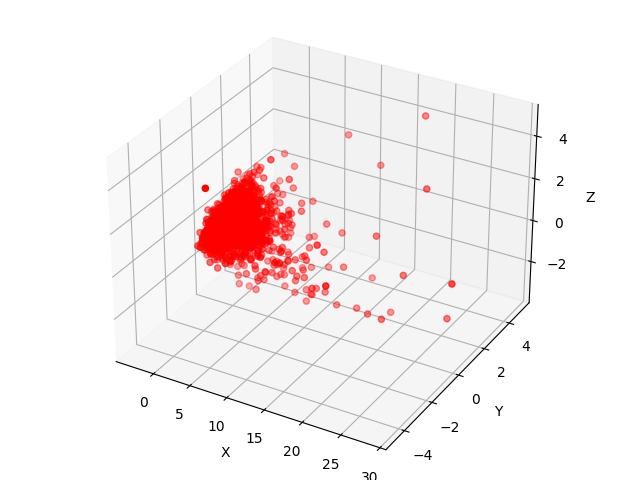

In [ ]:
# Representamos en un grafico de 3 dimensiones los embeddings creados
%matplotlib widget

fig = plt.figure()
axes = Axes3D(fig)
axes.scatter3D(embeddings_english2_3Dimensiones[:,0], embeddings_english2_3Dimensiones[:,1], 
               embeddings_english2_3Dimensiones[:,2], color="red")

# axes.set_xlim(min_x, max_x)
# axes.set_ylim(min_y, max_y)
# axes.set_zlim(min_z, max_z)

axes.set_title("Representacion embeddings ingles",fontsize=14,fontweight="bold")
axes.set_xlabel("X")
axes.set_ylabel("Y")
axes.set_zlabel("Z")
plt.tight_layout()
plt.show()

/var/folders/6t/lvrb7nj95pl1x9jzw9h6f0v80000gn/T/ipykernel_1739/3452095714.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)
/var/folders/6t/lvrb7nj95pl1x9jzw9h6f0v80000gn/T/ipykernel_1739/3452095714.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


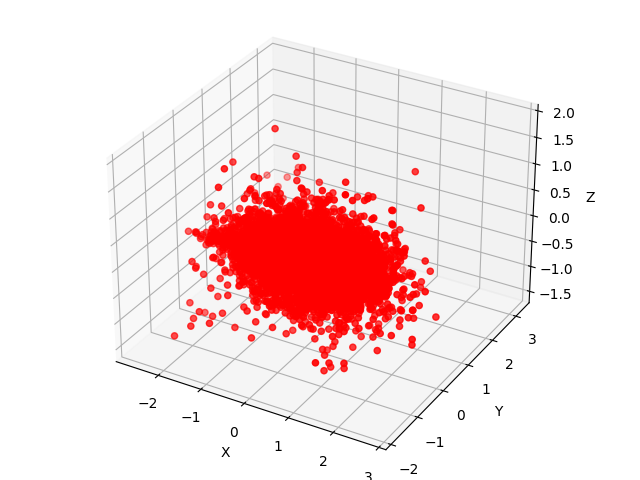

In [ ]:
# Representamos en un grafico de 3 dimensiones los embeddings creados
%matplotlib widget

fig = plt.figure()
axes = Axes3D(fig)
axes.scatter3D(embeddings_spanish2_3Dimensiones[:,0], embeddings_spanish2_3Dimensiones[:,1], 
               embeddings_spanish2_3Dimensiones[:,2], color="red")

# axes.set_xlim(min_x, max_x)
# axes.set_ylim(min_y, max_y)
# axes.set_zlim(min_z, max_z)

axes.set_title("Representacion embeddings ingles",fontsize=14,fontweight="bold")
axes.set_xlabel("X")
axes.set_ylabel("Y")
axes.set_zlabel("Z")
plt.tight_layout()
plt.show();

In [ ]:
pca = PCA(n_components=0.98, svd_solver='full')
embeddings_reducidos = pca.fit_transform(embeddings_english2)

print("Tenemos al inicio: ", embeddings_english2.shape)
print("Despues de aplicar PCA para mantener el 98% de la informacion queda: ", embeddings_reducidos.shape)

Tenemos al inicio:  (5666, 200)
Despues de aplicar PCA para mantener el 98% de la informacion queda:  (5666, 90)


## Obtencion matriz pesos R

In [ ]:
embeddings_english2 = pd.DataFrame(embeddings_english2,index = vocabulary_english)
embeddings_spanish2 = pd.DataFrame(embeddings_spanish2,index = vocabulary_spanish)

In [ ]:
traduccionLiteralEspanol = []
nuevoVocabIngles = []
doc = open('vocabulario en dos columnas', 'r', encoding="utf8")
for linea in doc:
    linea = linea.split()
    if(len(linea) <= 2):
        if(linea[1] in vocabulary_spanish):
            nuevoVocabIngles.append(linea[0])
            traduccionLiteralEspanol.append(linea[1])

In [ ]:
diccionarioInglesTrain, diccionarioInglesTest = train_test_split(nuevoVocabIngles, train_size=0.8, random_state=123)
diccionarioEspanolTrain, diccionarioEspanolTest = train_test_split(traduccionLiteralEspanol, train_size=0.8, random_state=123)


X_train = embeddings_english2.loc[diccionarioInglesTrain]
y_train = embeddings_spanish2.loc[diccionarioEspanolTrain]

X_test = embeddings_english2.loc[diccionarioInglesTest]
y_test = embeddings_spanish2.loc[diccionarioEspanolTest]

print("Dimension embeddings ingles para entrenar la R: ", X_train.shape)
print("Dimension embeddings español para entrenar la R: ", y_train.shape)

Dimension embeddings ingles para entrenar la R:  (2452, 200)
Dimension embeddings español para entrenar la R:  (2452, 200)


In [ ]:
embeddings_english2.shape

(5666, 200)

In [ ]:
N = size_embedding
R = np.random.randint(100, size=(N, N))/100
print("R inicializada aleatoriamente: \n", R)

R1 = gradientDescent(X_train, y_train, R, num_iters=3500)

print("\nR calculada: \n", R1)

R inicializada aleatoriamente: 
 [[0.25 0.36 0.44 ... 0.   0.99 0.67]
 [0.72 0.81 0.43 ... 0.24 0.16 0.73]
 [0.41 0.93 0.03 ... 0.16 0.81 0.01]
 ...
 [0.5  0.68 0.43 ... 0.57 0.9  0.79]
 [0.51 0.35 0.09 ... 0.19 0.7  0.01]
 [0.15 0.15 0.31 ... 0.21 0.97 0.64]]

R calculada: 
 [[ 2.49921911e-01  3.59920322e-01  4.39917436e-01 ... -7.65859648e-05
   9.89920932e-01  6.69921950e-01]
 [ 7.19931368e-01  8.09929384e-01  4.29927217e-01 ...  2.39932405e-01
   1.59930710e-01  7.29931149e-01]
 [ 4.09935127e-01  9.29933719e-01  2.99314658e-02 ...  1.59936513e-01
   8.09934129e-01  9.93547276e-03]
 ...
 [ 4.99937504e-01  6.79935625e-01  4.29934006e-01 ...  5.69938191e-01
   8.99936567e-01  7.89936985e-01]
 [ 5.09936497e-01  3.49935071e-01  8.99330159e-02 ...  1.89937611e-01
   6.99935402e-01  9.93664951e-03]
 [ 1.49938014e-01  1.49936385e-01  3.09934219e-01 ...  2.09939006e-01
   9.69937768e-01  6.39937929e-01]]


In [ ]:
salidaTest = (X_test).dot((R1))
salidaTrain = (X_train).dot((R1))

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(embeddings_spanish2, list(vocabulary_spanish))
prediccionTrain = knn.predict(salidaTrain)
prediccionTest = knn.predict(salidaTest)

In [ ]:
palabrasInglesTrain = np.array(diccionarioInglesTrain).reshape(-1,1)
palabrasTraducidasTrain = np.array(prediccionTrain).reshape(-1,1)
palabrasTraducidasBuenas = np.array(diccionarioEspanolTrain).reshape(-1,1)
traduccionesFinalesTrain = np.hstack((palabrasInglesTrain,palabrasTraducidasBuenas, palabrasTraducidasTrain))
traduccionesFinalesTrain = pd.DataFrame(traduccionesFinalesTrain,columns=['ingles','español','nuestras traducciones'])

In [ ]:
palabrasInglesTest = np.array(diccionarioInglesTest).reshape(-1,1)
palabrasTraducidasTest = np.array(prediccionTest).reshape(-1,1)
palabrasTraducidasBuenas = np.array(diccionarioEspanolTest).reshape(-1,1)
traduccionesFinalesTest = np.hstack((palabrasInglesTest,palabrasTraducidasBuenas, palabrasTraducidasTest))
traduccionesFinalesTest = pd.DataFrame(traduccionesFinalesTest,columns=['ingles','español','nuestras traducciones'])

In [ ]:
display(traduccionesFinalesTrain)

,ingles,español,nuestras traducciones
0,line,línea,cama
1,slits,rendijas,beso
2,jars,frascos,cama
3,pull,tirar,cama
4,guarded,guardado,gana
...,...,...,...
2447,plowed,arado,cama
2448,fire,fuego,cama
2449,sandy,arenoso,cama
2450,bungler,chapucero,anti


In [ ]:
display(traduccionesFinalesTest)

,ingles,español,nuestras traducciones
0,knock,golpe,cama
1,jump,saltar,cama
2,sides,lados,cama
3,bounds,límites,cama
4,trembling,temblor,cama
...,...,...,...
609,fur,piel,cielos
610,sorta,clase,cama
611,upon,sobre,cama
612,stalagmites,estalagmitas,gana


In [ ]:
print(np.count_nonzero(np.array(prediccionTest).reshape(-1,1) == np.array(diccionarioEspanolTest).reshape(-1,1)))
print(np.count_nonzero(np.array(prediccionTrain).reshape(-1,1) == np.array(diccionarioEspanolTrain).reshape(-1,1)))

0
1
